# Project: Mapping the State-Space of Stem Cell "Decisions"

### 1. Background : Stem Cell Differentiation
In biology, every cell in your body contains the same "source code" (DNA). However, a heart cell behaves differently from a neuron because they are "executing" different parts of that code. However, in order to reach their fates ('final' cell type), cells undergo a journey, the so called **cell differenciation** or **cell specification**.

Biologists often use the **Waddington Landscape** analogy: imagine a ball rolling down a hilly terrain. At the top (0h), the ball can go down many different valleys. By the bottom (168h), the ball is stuck in one specific path.

![alt text](waddington2.png)


### 2. Data

We quantify this execution by measuring the levels of **Gene Expression** throughout development.

In the current project, the data follows **Mouse Embryonic Stem Cells (ESCs)** over a period of 7 days (168 hours).
At $T=0$, the cells are "Pluripotent"—think of them as uninitialized objects that have the potential to become almost any tissue type. As time progresses, they interprete gene expression levels as signals to **differentiate**. At the end of the experiement, we get two cell types: **E14** and **R1**.

The **Single-Cell Gene Expression** dataset at our disposal is the following.
*   **Dimensions:** Each cell is a data object described by **96 features** (different marker genes, in addition to time and type of cell).

| Feature | Type | Description |
| :--- | :--- | :--- |
| **Time** | `int` | The timestamp of the snapshot (0h, 24h, 48h, 72h, 96h, 120h, 168h). |
| **Type** | `string` | The cell line background (**E14** or **R1**). These are two different "classes" of stem cells. |
| **Genes** | `float` | **96 columns** (e.g., *Actb, Nanog, Sox2...*). These represent the normalized expression level of specific genes. |


***
*Data Source & Paper: Patrick S. Stumpf, "Stem Cell Differentiation as a Non-Markov Stochastic Process," Cell Systems, 2017.*

### Part 1. Load the dataset
Read the "gene_expression_data.csv" dataset into a pandas dataframe.

Once loaded, you can use the "head()", "info()" or "describe()" functions for an overview of the dataset and its summary statistics. Below is an example result of head() applied to the dataset.

![alt text](head.png)

Tip: Because the dataset, although high-dimensional, only has 96 columns, you can also open the dataset using Excel and view it in tabular form by using the the "text-to-columns" feature of MS Excel (https://www.youtube.com/watch?v=QyZ6IMkln2U).

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use("dark_background")

df = pd.read_csv("gene_expression_data.csv")
print(df.head())
print(df.info())
print(df.isnull().sum())

          Sample  Time Type       Actb      Bmi1       Bmp4  Bmp7     Bmpr1a  \
0  E14tg2a.0h.1A     0  E14  16.716759   0.00000  26.183448   0.0  25.493528   
1  E14tg2a.0h.1B     0  E14  11.283763   0.00000  15.379562   0.0  18.535507   
2  E14tg2a.0h.1C     0  E14  11.356264   0.00000  15.305810   0.0   0.000000   
3  E14tg2a.0h.1D     0  E14  10.923010  18.05053  16.744032   0.0  17.100323   
4  E14tg2a.0h.1E     0  E14  10.334779  18.60766  16.693236   0.0  17.364452   

   Cd34       Cdh1  ...      Trp53      Tubb3       Utf1        Vim  \
0   0.0  25.754394  ...  22.225853  25.431561  22.266882  21.747678   
1   0.0   0.000000  ...  13.895273  13.837472  16.676966  12.199917   
2   0.0   0.000000  ...  14.426960  15.933678  19.744670  11.956928   
3   0.0   0.000000  ...  14.508559  13.673305  16.911726  11.703409   
4   0.0   0.000000  ...  13.763772  12.942459  16.411662  11.049555   

        Wdr5      Wnt3a  Wnt5a     Zfp281      Zfp42  Unnamed: 99  
0  22.577380   0.000000 

### Part 2. Visualize some data
Because the dataset is high-dimensional (cells are described across 96 genes), we canNOT visualize all genes. In this part, we will restrict our focus on two genes: "Bmp4" and "Nanog".

Create a figure with two plots (one for each gene), where each plot shows, at each time (0H, 24H, ..., 168H), the statistics of expresssion levels of the genes in cells. What plot types are appropriate for this ?
Hint: you may want to have time on the x-asis  

Bonus: There are two types of cells in the dataset (E14 and R1). Can you enhance the plot to visualize the expression levels within each cell type ? What do you observe ?

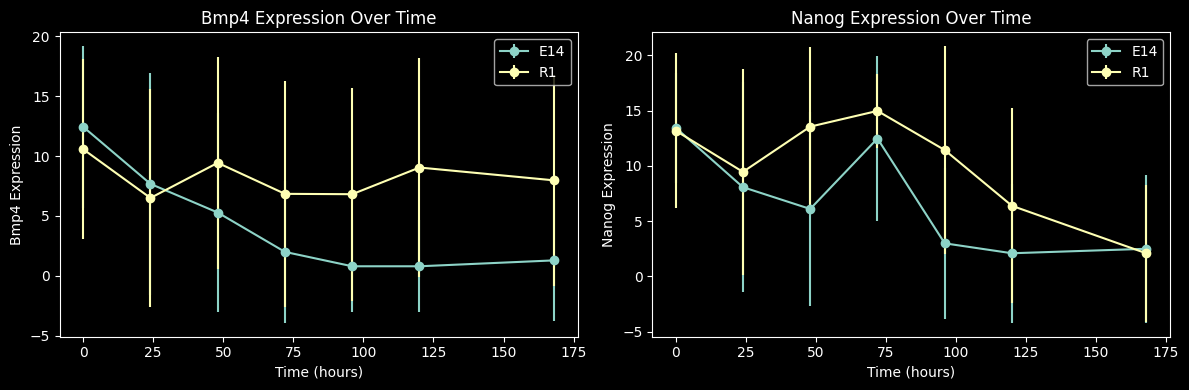

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for cell_type in df['Type'].unique():
    subset = df[df['Type'] == cell_type]
    bmp4_mean = subset.groupby('Time')['Bmp4'].mean()
    bmp4_std = subset.groupby('Time')['Bmp4'].std()
    axes[0].errorbar(bmp4_mean.index, bmp4_mean.values, yerr=bmp4_std.values, marker='o', label=cell_type)

    nanog_mean = subset.groupby('Time')['Nanog'].mean()
    nanog_std = subset.groupby('Time')['Nanog'].std()
    axes[1].errorbar(nanog_mean.index, nanog_mean.values, yerr=nanog_std.values, marker='o', label=cell_type)

axes[0].set_xlabel('Time (hours)')
axes[0].set_ylabel('Bmp4 Expression')
axes[0].set_title('Bmp4 Expression Over Time')
axes[0].legend()

axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel('Nanog Expression')
axes[1].set_title('Nanog Expression Over Time')
axes[1].legend()

plt.tight_layout()
plt.show()

### Part 3. Relationships between genes
Because the dataset is high-dimensional (cells are described across 96 genes), we canNOT visualize all relationships between our variables (genes). However, as in almost every real-world datasets, variables entertain strong or weak relations. In this part, we will try to identity which genes that have strong ties, and attempt to visualize how the behave together.

Once more, because the dataset is multi-dimensional, we will restrict our analysis to the subset of genes (although we can get away with an analysis of the whole set of genes in our current scenario of 96 genes)

    genes = ['Nanog', 'Pou5f1', 'Sox2', 'Gata6', 'Pax6', 'Sox1', 'Actb', 'Bmp4'].

Create a figure with the following plots:

1. A **correlation heatmap** showing the correlations of all genes above at time O
2. A **correlation heatmap** showing the correlations of all genes above at time 168
3. From the first plot, pick the two genes with the highest correlation and create a **scatter plot** of both. Does the scatter trend verify the observed correlation ? Compare their correlation at time 168. What do you observe ?
4. From the second plot, pick the two genes with the highest correlation and create a **scatter plot** of both. Does the scatter trend verify the observed correlation ? Compare their correlation at time 0. What do you observe ?

Bonus: i.Think about improvements you could make on the scatter plots. What comes to mind ? Create a figure with two plots (Hint: different colors and/or markers for the two different cell types, etc.)
ii. How does the relationship of the 2 genes picked at (3.) evolve through all time points (0,24,48,72,69,120,144,168) ? What plot(s) can you use for this ?

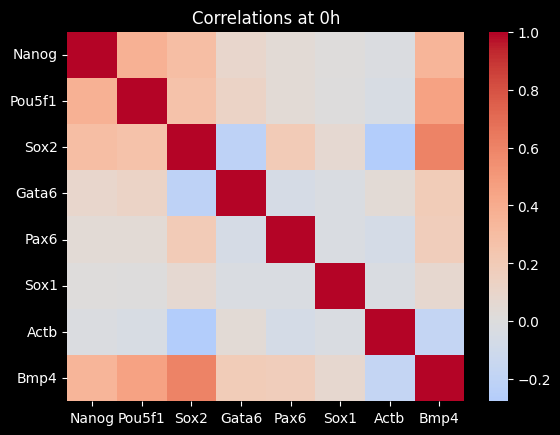

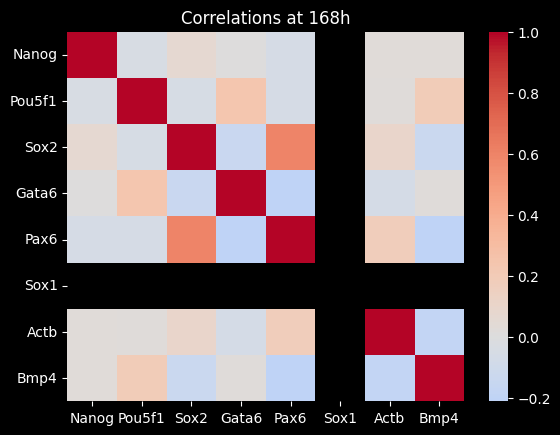

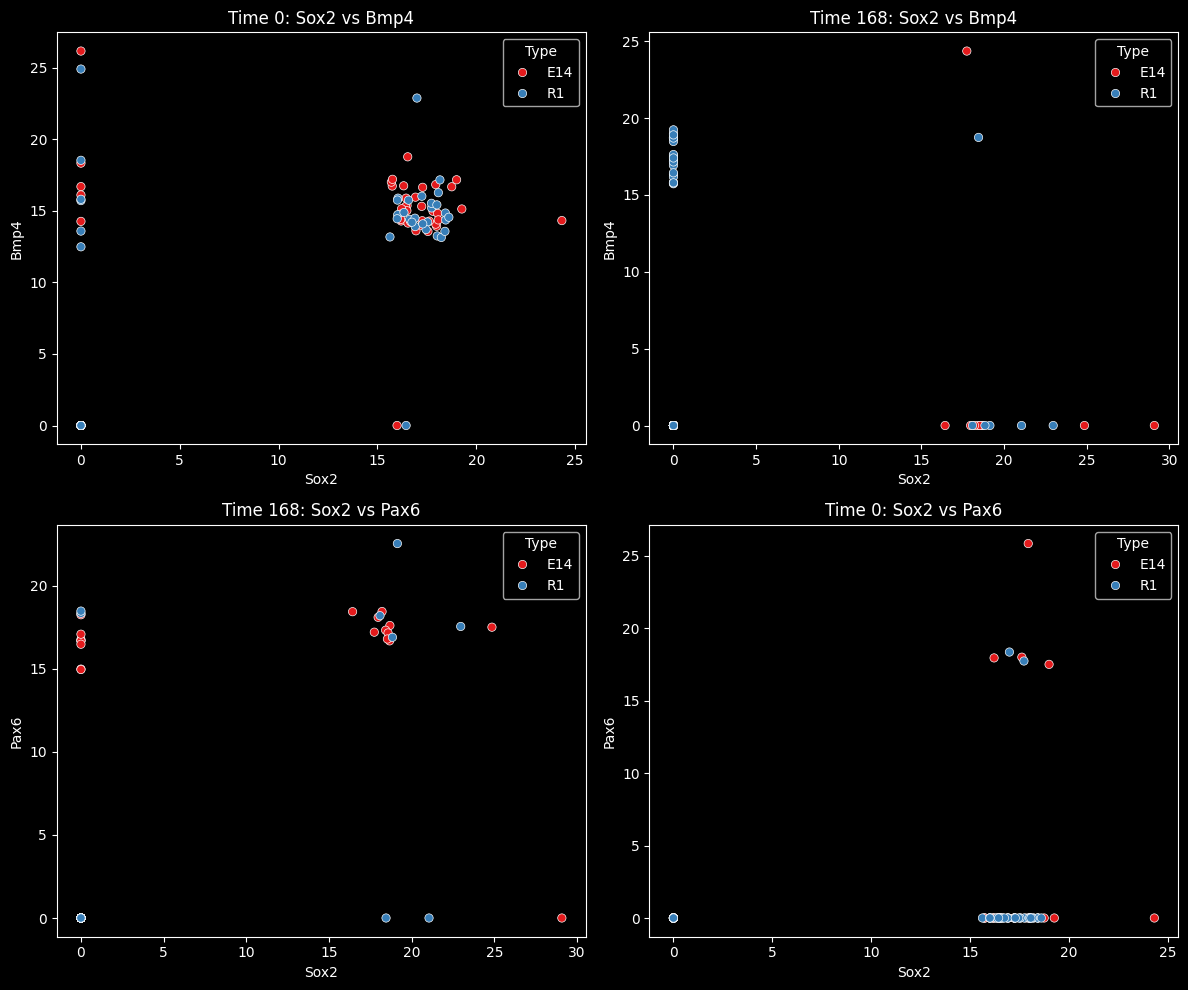

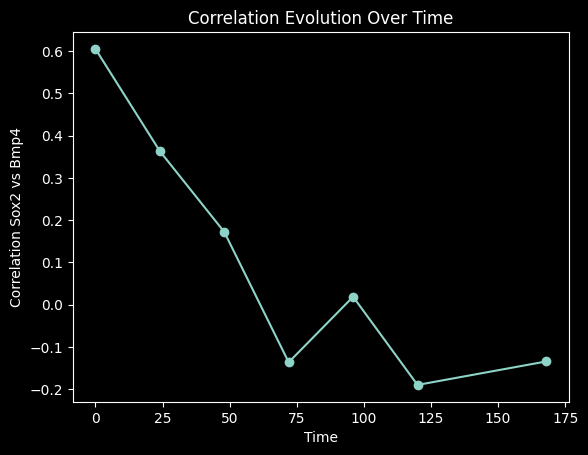

In [12]:
genes = ["Nanog", "Pou5f1", "Sox2", "Gata6", "Pax6", "Sox1", "Actb", "Bmp4"]

t0 = df[df["Time"] == 0]
t168 = df[df["Time"] == 168]

corr0 = t0[genes].corr()
corr168 = t168[genes].corr()

plt.figure()
sns.heatmap(corr0, cmap="coolwarm", center=0)
plt.title("Correlations at 0h")
plt.show()

plt.figure()
sns.heatmap(corr168, cmap="coolwarm", center=0)
plt.title("Correlations at 168h")
plt.show()

corr0_abs = corr0.abs()
np.fill_diagonal(corr0_abs.values, 0)
g1_0, g2_0 = corr0_abs.stack().idxmax()

corr168_abs = corr168.abs()
np.fill_diagonal(corr168_abs.values, 0)
g1_168, g2_168 = corr168_abs.stack().idxmax()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(x=t0[g1_0], y=t0[g2_0], hue=t0['Type'], palette='Set1', ax=axes[0,0])
axes[0,0].set_title(f"Time 0: {g1_0} vs {g2_0}")

sns.scatterplot(x=t168[g1_0], y=t168[g2_0], hue=t168['Type'], palette='Set1', ax=axes[0,1])
axes[0,1].set_title(f"Time 168: {g1_0} vs {g2_0}")

sns.scatterplot(x=t168[g1_168], y=t168[g2_168], hue=t168['Type'], palette='Set1', ax=axes[1,0])
axes[1,0].set_title(f"Time 168: {g1_168} vs {g2_168}")

sns.scatterplot(x=t0[g1_168], y=t0[g2_168], hue=t0['Type'], palette='Set1', ax=axes[1,1])
axes[1,1].set_title(f"Time 0: {g1_168} vs {g2_168}")

plt.tight_layout()
plt.show()

times = sorted(df['Time'].unique())
corr_evolution = []
for t in times:
    temp = df[df['Time']==t]
    corr_val = temp[[g1_0, g2_0]].corr().iloc[0,1]
    corr_evolution.append(corr_val)

plt.plot(times, corr_evolution, marker='o')
plt.xlabel("Time")
plt.ylabel(f"Correlation {g1_0} vs {g2_0}")
plt.title("Correlation Evolution Over Time")
plt.show()

### Part 4. Dimensionality Reduction (PCA)
We can only do so much in trying to visualize our dataset one variable at the time, or 2 variables at the time. Our dataset is high-dimensional, we must therefore use appropriate methods to visualize it. Most notably, dimensionality reduction methods.

1. Perform **Principal Component Analysis (PCA)** on the data, keeping only 2 dimensions
(Hint: you don't need to pass columns 'Time' and 'Type' to PCA as they do not contain information on genes. Extract just genes columns and pass it to PCA. The line below shows how you can 'drop' those columns)

    X = df.drop(['Time', 'Type'], axis=1)

2. Determine the 'importance' of each of your principal component ? How do you inteprete that ?

3. Create a scatter plot on the resulting two dimensional data (PC1 vs PC2). What do you observe ? Can you identified different trajectories in time for different cell types (E14, R1) ?

4. Enhance the scatter plot using different marker types for cell type (E14, R1) and different colors for time (0, 24, ..., 268). What do you observe ?

Bonus: Perform **Principal Component Analysis (PCA)** on the data, this time keeping 3 dimensions. Redo steps 1-4

Explained variance ratio: [0.20098032 0.0688953 ]


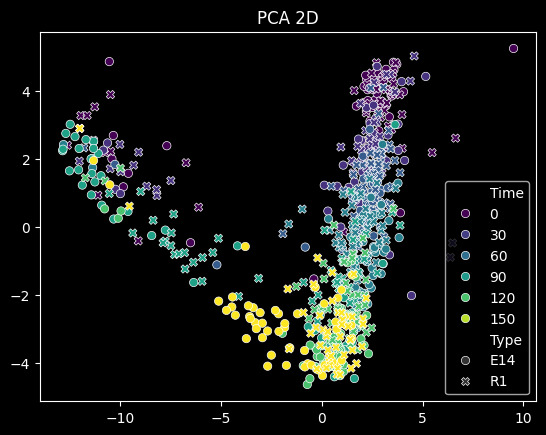

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("dark_background")

X_pca_data = df.drop(["Time", "Type"], axis=1)
X_pca_data = X_pca_data.select_dtypes(include=np.number)
X_pca_data.replace([np.inf, -np.inf], np.nan, inplace=True)
X_pca_data.dropna(axis=1, how='all', inplace=True)
X_pca_data = X_pca_data.fillna(X_pca_data.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure()
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["Time"], style=df["Type"], palette="viridis")
plt.title("PCA 2D")
plt.show()

### Part 5. Dimensionality Reduction (Non-linear methods)
Non-linear dimensionality reduction (t-SNE, UMAP) methods usually produce better visualisations than PCA

1. Redo steps 1,3,4 of the previous part (keeping only 2 components, then 3 components) using a non-linear reduction method of your choice (**t-SNE** or **UMAP**). What do you observe ? How is the visulisation produced compared to the visual result of PCA ?


Bonus: Redo step 1 using the dimensionality reduction method **isomap** (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)

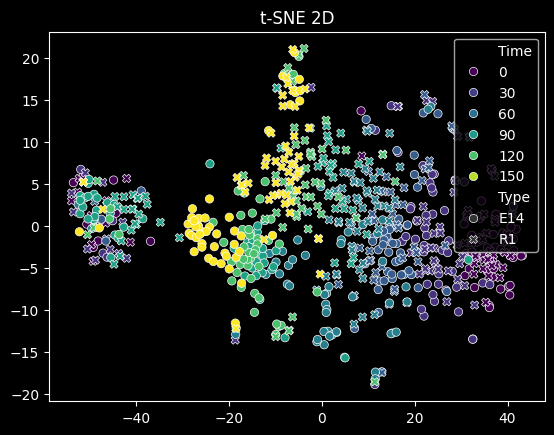

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("dark_background")

X_tsne_data = df.drop(["Time", "Type"], axis=1)
X_tsne_data = X_tsne_data.select_dtypes(include=np.number)
X_tsne_data.replace([np.inf, -np.inf], np.nan, inplace=True)
X_tsne_data.dropna(axis=1, how='all', inplace=True)
X_tsne_data = X_tsne_data.fillna(X_tsne_data.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tsne_data)

tsne = TSNE(n_components=2, random_state=0, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure()
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df["Time"], style=df["Type"], palette="viridis")
plt.title("t-SNE 2D")
plt.show()